In [0]:
! pip install data

In [0]:
! pip install --upgrade tensorflow==2.0.0-rc1

Requirement already up-to-date: tensorflow==2.0.0-rc1 in /usr/local/lib/python3.6/dist-packages (2.0.0rc1)


In [0]:
# !pip install tensorflow_addons

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0


EDSR MODEL(Enhanced Deep Residual for Single Image Super Resolution)

In [0]:
#EDSR Model
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.python.data.experimental import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

DIV2K_RGBMEAN = np.array([0.4488, 0.4371, 0.4040]) * 255


def edsrmodel(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    x_input = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_input)

    x = a = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        a = resblock(a, num_filters, res_block_scaling)
    a = Conv2D(num_filters, 3, padding='same')(a)
    x = Add()([x, a])

    x = up_sample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_input, x, name="edsr")


def resblock(x_input, filters, scaling):
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_input)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_input, x])
    return x


def up_sample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixelshuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

def pixelshuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

def normalize(x):
    a = (x - DIV2K_RGBMEAN) / 127.5
    return a

def denormalize(x):
    a = x * 127.5 + DIV2K_RGBMEAN
    return a

In [0]:
#data
class DIV2K:
    def __init__(self,
                 scale=2,
                 subset='train',
                 downgrade='bicubic',
                 imgs_dir='.div2k/images',
                 caches_dir='.div2k/caches'):

        self._ntire_2018 = True

        scales = [2, 3, 4, 8]

        if scale in scales:
            self.scale = scale
        else:
            raise ValueError(f'scale must be in ${scales}')

        if subset == 'train':
            self.image_ids = range(1, 801)
        elif subset == 'valid':
            self.image_ids = range(801, 901)
        else:
            raise ValueError("subset should be 'train' or 'valid'")

        downgrades_a = ['bicubic', 'unknown']
        downgrades_b = ['mild', 'difficult']

        if scale == 8 and downgrade != 'bicubic':
            raise ValueError(f'scale 8 is only allowed for bicubic downgrade')

        if downgrade in downgrades_b and scale != 4:
            raise ValueError(f'{downgrade} downgrade requires a scale 4')

        if downgrade == 'bicubic' and scale == 8:
            self.downgrade = 'x8'
        elif downgrade in downgrades_b:
            self.downgrade = downgrade
        else:
            self.downgrade = downgrade
            self._ntire_2018 = False

        self.subset = subset
        self.imgs_dir = imgs_dir
        self.caches_dir = caches_dir

        os.makedirs(imgs_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        return len(self.image_ids)

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        data = tf.data.Dataset.zip((self.lr_dataset(), self.hr_dataset()))
        if random_transform:
            data = data.map(lambda lr, hr: crop(lr, hr, scale=self.scale), num_parallel_calls=AUTOTUNE)
            data = data.map(rotate, num_parallel_calls=AUTOTUNE)
            data = data.map(flip, num_parallel_calls=AUTOTUNE)
        data = data.batch(batch_size)
        data = data.repeat(repeat_count)
        data = data.prefetch(buffer_size=AUTOTUNE)
        return data

    def hr_dataset(self):
        if not os.path.exists(self.hr_imagesdir()):
            download_archive(self.hr_imagesarchive(), self.imgs_dir, extract=True)

        data = self.images_dataset(self.hr_imagefiles()).cache(self.hr_cachefile())

        if not os.path.exists(self.hr_cacheindex()):
            self.populate_cache(data, self.hr_cachefile())

        return data

    def lr_dataset(self):
        if not os.path.exists(self.lr_imagesdir()):
            download_archive(self.lr_imagesarchive(), self.imgs_dir, extract=True)

        data = self.images_dataset(self.lr_imagefiles()).cache(self.lr_cachefile())

        if not os.path.exists(self.lr_cacheindex()):
            self.populate_cache(data, self.lr_cachefile())

        return data

    def hr_cachefile(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_HR.cache')

    def lr_cachefile(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.cache')

    def hr_cacheindex(self):
        return f'{self.hr_cachefile()}.index'

    def lr_cacheindex(self):
        return f'{self.lr_cachefile()}.index'

    def hr_imagefiles(self):
        imgs_dir = self.hr_imagesdir()
        return [os.path.join(imgs_dir, f'{image_id:04}.png') for image_id in self.image_ids]

    def lr_imagefiles(self):
        imgs_dir = self.lr_imagesdir()
        return [os.path.join(imgs_dir, self.lr_imagefile(image_id)) for image_id in self.image_ids]

    def lr_imagefile(self, image_id):
        if not self._ntire_2018 or self.scale == 8:
            return f'{image_id:04}x{self.scale}.png'
        else:
            return f'{image_id:04}x{self.scale}{self.downgrade[0]}.png'

    def hr_imagesdir(self):
        return os.path.join(self.imgs_dir, f'DIV2K_{self.subset}_HR')

    def lr_imagesdir(self):
        if self._ntire_2018:
            return os.path.join(self.imgs_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}')
        else:
            return os.path.join(self.imgs_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}', f'X{self.scale}')

    def hr_imagesarchive(self):
        return f'DIV2K_{self.subset}_HR.zip'

    def lr_imagesarchive(self):
        if self._ntire_2018:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}.zip'
        else:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.zip'

    @staticmethod
    def images_dataset(image_files):
        data = tf.data.Dataset.from_tensor_slices(image_files)
        data = data.map(tf.io.read_file)
        data = data.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return data

    @staticmethod
    def populate_cache(data, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in data: pass
        print(f'Cached decoded images in {cache_file}.')



In [0]:
#Data Augmentation
def crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    lr_cropsize = hr_crop_size // scale
    lr_imgshape = tf.shape(lr_img)[:2]

    lr__w = tf.random.uniform(shape=(), maxval=lr_imgshape[1] - lr_cropsize + 1, dtype=tf.int32)
    lr__h = tf.random.uniform(shape=(), maxval=lr_imgshape[0] - lr_cropsize + 1, dtype=tf.int32)

    hr__w = lr__w * scale
    hr__h = lr__h * scale

    lr_imgcropped = lr_img[lr__h:lr__h + lr_cropsize, lr__w:lr__w + lr_cropsize]
    hr_imgcropped = hr_img[hr__h:hr__h + hr_crop_size, hr__w:hr__w + hr_crop_size]

    return lr_imgcropped, hr_imgcropped


def flip(lr_img, hr_img):
    r = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(r < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def rotate(lr_img, hr_img):
    r = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, r), tf.image.rot90(hr_img, r)


In [0]:
#Data Download
def download_archive(file, target_dir, extract=True):
    source = f'http://data.vision.ee.ethz.ch/cvl/DIV2K/{file}'
    target_dir = os.path.abspath(target_dir)
    tf.keras.utils.get_file(file, source, cache_subdir=target_dir, extract=extract)
    os.remove(os.path.join(target_dir, file))


In [0]:
train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_data = train.dataset(batch_size=16, random_transform=True)

In [0]:
weights_dir = 'weights/article'
os.makedirs(weights_dir, exist_ok=True)

In [0]:
#Train EDSR Model
model_edsr = edsrmodel(scale=4, num_res_blocks=16)

optim_edsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5]))

model_edsr.compile(optimizer=optim_edsr, loss='mean_absolute_error')
model_edsr.fit(train_ds, epochs=300, steps_per_epoch=1000)

# Save model weights
model_edsr.save_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

Train for 10 steps
10/10 [==============================] - 3s 286ms/step - loss: 71.6938


In [0]:
#Common functions
DIV2K_RGBMEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def _resolve_single(model, lr):
    return _resolve(model, tf.expand_dims(lr, axis=0))[0]

def _resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch

def evaluate(model, dataset):
    psnr_values = []
    for lr, hr in dataset:
        sr = _resolve(model, lr)
        psnr_value = psnr(hr, sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)

def normalize(x, rgb_mean=DIV2K_RGBMEAN):
    a = (x - rgb_mean) / 127.5
    return a

def denormalize(x, rgb_mean=DIV2K_RGBMEAN):
    a = x * 127.5 + rgb_mean
    return a

def normalize_01(x):
    a = x / 255.0
    return a

def normalize_m11(x):
    a = x / 127.5 - 1
    return a

def denormalize_m11(x):
    a = (x + 1) * 127.5
    return a

def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)

def pixelshuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

WDSR ( Wide Activation for Efficient and Accurate Image Super-Resolution)


In [0]:
# WDSR
import tensorflow_addons as tfa

from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.python.keras.models import Model

def _wdsr_a(scale, num_filters=32, num_res_blocks=8, res_block_expansion=4, res_block_scaling=None):
    return wdsrmodel(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, resblock_a)

def _wdsr_b(scale, num_filters=32, num_res_blocks=8, res_block_expansion=6, res_block_scaling=None):
    return wdsrmodel(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, resblock_b)

def wdsrmodel(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block):
    x_input = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_input)

    mb = conv2d_weightnorm(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        mb = res_block(mb, num_filters, res_block_expansion, kernel_size=3, scaling=res_block_scaling)
    mb = conv2d_weightnorm(3 * scale ** 2, 3, padding='same', name=f'conv2d_main_scale_{scale}')(mb)
    mb = Lambda(pixelshuffle(scale))(mb)

    sb = conv2d_weightnorm(3 * scale ** 2, 5, padding='same', name=f'conv2d_skip_scale_{scale}')(x)
    sb = Lambda(pixelshuffle(scale))(sb)

    x = Add()([mb, sb])
    x = Lambda(denormalize)(x)

    return Model(x_input, x, name="wdsr")

def resblock_a(x_input, num_filters, expansion, kernel_size, scaling):
    x = conv2d_weightnorm(num_filters * expansion, kernel_size, padding='same', activation='relu')(x_input)
    x = conv2d_weightnorm(num_filters, kernel_size, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_input, x])
    return x

def resblock_b(x_input, num_filters, expansion, kernel_size, scaling):
    linear = 0.8
    x = conv2d_weightnorm(num_filters * expansion, 1, padding='same', activation='relu')(x_input)
    x = conv2d_weightnorm(int(num_filters * linear), 1, padding='same')(x)
    x = conv2d_weightnorm(num_filters, kernel_size, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_input, x])
    return x

def conv2d_weightnorm(filters, kernel_size, padding='same', activation=None, **kwargs):
    return tfa.layers.WeightNormalization(Conv2D(filters, kernel_size, padding=padding, activation=activation, **kwargs), data_init=False)


In [0]:
#Train WDSR Model
model_wdsr = _wdsr_b(scale=4, num_res_blocks=32)

optim_wdsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-3, 5e-4]))

model_wdsr.compile(optimizer=optim_wdsr, loss='mean_absolute_error')
model_wdsr.fit(train_ds, epochs=300, steps_per_epoch=1000)

model_wdsr.save_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))

Train for 10 steps
10/10 [==============================] - 104s 10s/step - loss: 171.0022


In [0]:
# SRGAN
from tensorflow.python.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg19 import VGG19

LR_Size = 24
HR_Size = 96


def up_sample(x_in, num_filters):
    z = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    z = Lambda(pixelshuffle(scale=2))(z)
    return PReLU(shared_axes=[1, 2])(z)

def res_block(x_in, num_filters, momentum=0.8):
    z = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    z = BatchNormalization(momentum=momentum)(z)
    z = PReLU(shared_axes=[1, 2])(z)
    z = Conv2D(num_filters, kernel_size=3, padding='same')(z)
    z = BatchNormalization(momentum=momentum)(z)
    x = Add()([x_input, z])
    return x

def sr_resnet(num_filters=64, num_res_blocks=16):
    x_input = Input(shape=(None, None, 3))
    z = Lambda(normalize_01)(x_input)

    z = Conv2D(num_filters, kernel_size=9, padding='same')(z)
    z = x1 = PReLU(shared_axes=[1, 2])(z)

    for _ in range(num_res_blocks):
        z = res_block(z, num_filters)

    z = Conv2D(num_filters, kernel_size=3, padding='same')(z)
    z = BatchNormalization()(z)
    z = Add()([x1, z])

    z = up_sample(z, num_filters * 4)
    z = up_sample(z, num_filters * 4)

    z = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(z)
    x = Lambda(denormalize_m11)(z)

    return Model(x_input, x)

gen = sr_resnet

def discriminator_block(x_input, num_filters, strides=1, batchnorm=True, momentum=0.8):
    z = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_input)
    if batchnorm:
        z = BatchNormalization(momentum=momentum)(z)
    return LeakyReLU(alpha=0.2)(z)

def discriminator(num_filters=64):
    x_input = Input(shape=(HR_Size, HR_Size, 3))
    z = Lambda(normalize_m11)(x_input)

    z = discriminator_block(z, num_filters, batchnorm=False)
    z = discriminator_block(z, num_filters, strides=2)

    z = discriminator_block(z, num_filters * 2)
    z = discriminator_block(z, num_filters * 2, strides=2)

    z = discriminator_block(z, num_filters * 4)
    z = discriminator_block(z, num_filters * 4, strides=2)

    z = discriminator_block(z, num_filters * 8)
    z = discriminator_block(z, num_filters * 8, strides=2)

    z = Flatten()(z)

    z = Dense(1024)(z)
    z = LeakyReLU(alpha=0.2)(z)
    x = Dense(1, activation='sigmoid')(z)

    return Model(x_input, x)

def vgg_22():
    return vgg(5)

def vgg_54():
    return vgg(20)

def vgg(output_layer):
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)
    return Model(vgg.input, vgg.layers[output_layer].output)

In [0]:

mse = tf.keras.losses.MeanSquaredError()

binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

vgg = vgg_54()

gen = _wdsr_b(scale=4, num_res_blocks=32)
gen.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))

discriminator = discriminator()

schedule = PiecewiseConstantDecay(boundaries=[10], values=[1e-4, 1e-5])
gen_optimizer = Adam(learning_rate=schedule)
disc_optimizer = Adam(learning_rate=schedule)

def generatorloss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

def discriminatorloss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

@tf.function
def contentloss(hr, sr):
    sr = tf.keras.applications.vgg19.preprocess_input(sr)
    hr = tf.keras.applications.vgg19.preprocess_input(hr)
    sr_features = vgg(sr) / 12.75
    hr_features = vgg(hr) / 12.75
    return mse(hr_features, sr_features)

@tf.function
def trainstep(lr, hr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        sr = gen(lr, training=True)
        hr_out = discriminator(hr, training=True)
        sr_out = discriminator(sr, training=True)

        con_loss = contentloss(hr, sr)
        gen_loss = generatorloss(sr_out)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = discriminatorloss(hr_out, sr_out)

    gradients_of_generator = gen_tape.gradient(perc_loss, gen.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return perc_loss, disc_loss

pls_metric = tf.keras.metrics.Mean()
dls_metric = tf.keras.metrics.Mean()

steps = 200000
step = 0

# Train SRGAN for 200,000 steps.
for lr, hr in train_data.take(steps):
    step += 1

    pl, dl = trainstep(lr, hr)
    pls_metric(pl)
    dls_metric(dl)

    if step % 50 == 0:
        print(step)
        print(f'{step}/{steps}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
        pls_metric.reset_states()
        dls_metric.reset_states()
        
gen.save_weights(os.path.join(weights_dir, 'weights-edsr-16-x4-fine-tuned.h5'))

KeyboardInterrupt: ignored

In [0]:
# ---------------------------------

In [0]:
# utils
import matplotlib.pyplot as plt

from PIL import Image

def loadimage(path):
    return np.array(Image.open(path))


def plotsample(lr, sr):
    plt.figure(figsize=(20, 15))

    imgs = [lr, sr]
    titles = ['LR', f'SR (x{sr.shape[0] // lr.shape[0]})']

    for i, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [0]:
import os
import matplotlib.pyplot as plt

%matplotlib inline

def resolve_and_plot(model_pre_trained, model_fine_tuned, lr_image_path):
    lr = loadimage(lr_image_path)
    
    sr_pt = _resolve_single(model_pre_trained, lr)
    sr_ft = _resolve_single(model_fine_tuned, lr)
    
    plt.figure(figsize=(10, 10))
    
    model_name = model_pre_trained.name.upper()
    imgs = [lr, sr_pt, sr_ft]
    titles = ['LR', f'SR ({model_name}, pixel loss)', f'SR ({model_name}, perceptual loss)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(imgs, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        
weights_dir = 'weights/article'

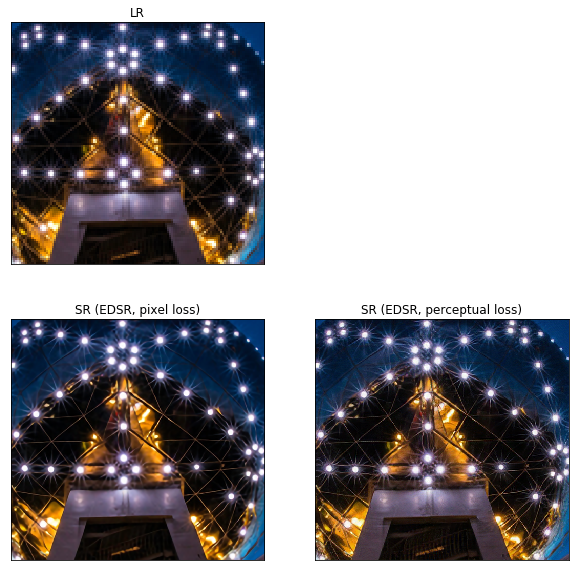

In [0]:

edsr_pre_trained = edsrmodel(scale=4, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

edsr_fine_tuned = edsrmodel(scale=4, num_res_blocks=16)
edsr_fine_tuned.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4-fine-tuned.h5'))

resolve_and_plot(edsr_pre_trained, edsr_fine_tuned, 'demo/0851x4-crop_3.png')

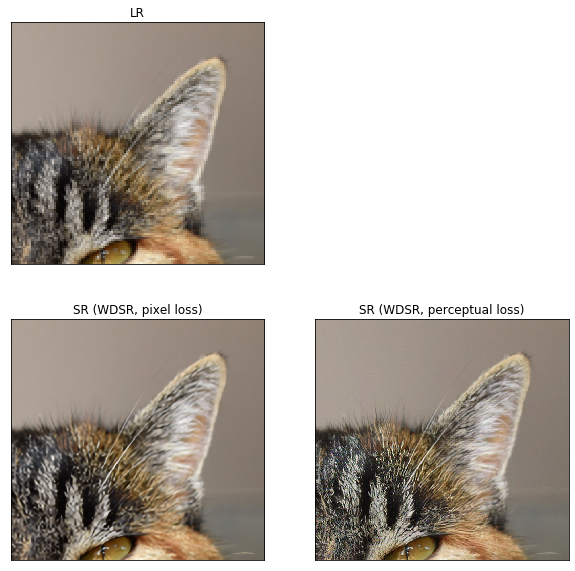

In [0]:
# from model.wdsr import wdsr_b

wdsr_pre_trained = _wdsr_b(scale=4, num_res_blocks=32)
wdsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))

wdsr_fine_tuned = _wdsr_b(scale=4, num_res_blocks=32)
wdsr_fine_tuned.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4-fine-tuned.h5'))

resolve_and_plot(wdsr_pre_trained, wdsr_fine_tuned, 'demo/0869x4-crop.png')